Engrasandonos las manos con datos

En este proyecto vamos a seguir trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es continuar con la limpieza de datos y avanzar en remover valores faltantes y remover outliers. Por otro lado, vamos a agregar nuevos atributos basados en los datos.

## Dataset: Propiedades en venta en Ciudad de Buenos Aires.

En este proyecto, trabajaremos con una muestra del conjunto de datos de propiedades en venta mencionado. En este dataset, cada fila es una propiedad en venta. A continuación vamos a describir los atributos que consideramos en esta muestra:

* id: id de la propiedad
* created_on: fecha en la que la propiedad ingresó al sitio
* operation: alquiler (rent) o venta (sell)
* property_type: tipo de propiedad (casa, departamento, ph, etcétera)
* place_with_parent_names: nombre del lugar donde se encuentra la propiedad según el publicador
* lat-lon: coordenadas concatenadas
* lat: latitud
* lon: longitud
* price: precio en la moneda especificada en currency
* currency: divisa en la que está expresada la publicación
* price_aprox_usd: precio aproximado en dólares estadounidenses
* surface_total_in_m2: superficie total (en metros cuadrados)
* surface_covered_in_m2: superficie cubierta (en metros cuadrados)
* price_usd_per_m2: precio por metro cuadrado en dólares (precio dólares / superficie)
* floor: número de piso (si corresponde)
* rooms: cantidad de ambientes
* expenses: expensas (si corresponde)
* barrio: barrio según cartografía oficial
* properati_url: url de la publicación en Properati

A continuación vamos a levantar el dataset para comenzar el procesamiento. Cabe destacar que en este caso ya fueron hechas las correcciones de coordenadas y superficies incorrectas que vimos en el proyecto anterior

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

plt.rcParams['figure.figsize'] = (12,5)

In [2]:
%config IPCompleter.greedy=True

In [3]:
path_dataset = 'dataset/datos_properati_limpios.csv'
df = pd.read_csv(path_dataset, parse_dates=['created_on'])

In [4]:
df.columns

Index(['created_on', 'property_type', 'place_name', 'place_with_parent_names',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses', 'properati_url', 'barrio'],
      dtype='object')

In [5]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 13756 observaciones


### Outliers

Analicemos en primer lugar los valores extremos que puede haber en los precios y en las superficies. Esto nos va a ser útil para luego imputar usando medidas de tendencia central, como el promedio. 
Recordemos que las medidas de tendencia central pueden ser sensibles a outliers, por lo que la imputación de valores faltantes puede verse afectada

Una posible pregunta que surge es si conviene primero imputar faltantes y luego remover outliers, o lo contrario.  Cuando se imputa se modifica la distribución de los datos. Por eso, las cotas que utilicemos para definir los outliers se verán afectadas por este cambio y modificarán los resultados finales. Entonces comenzaremos quitando outliers.

Vamos a trabajar con `price_usd_per_m2`. Precios altos pueden corresponderse con grandes superficies, por lo que conviene analizar juntos ambos atributos. Veamos la distribución de los valores y un boxplot para comenzar a identificar los outliers.

In [6]:
df.dropna(subset=['price_usd_per_m2'],inplace=True)

In [7]:
df.price_usd_per_m2.isnull().sum()

0

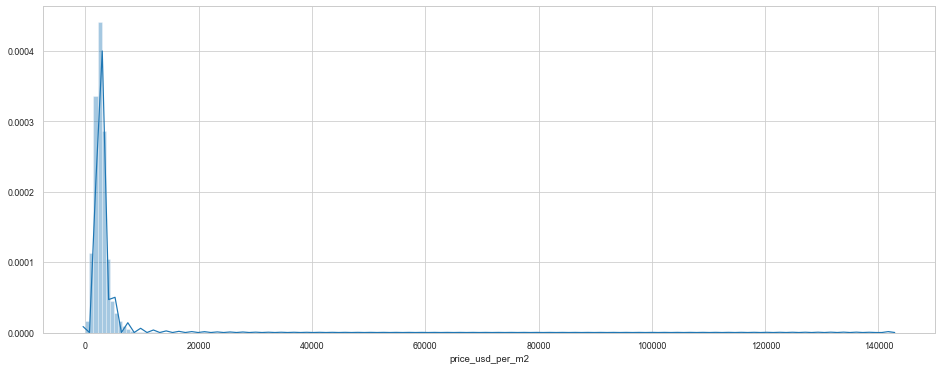

In [8]:
plt.figure(figsize=(16,6))
sns.distplot(df['price_usd_per_m2'], bins = 200)

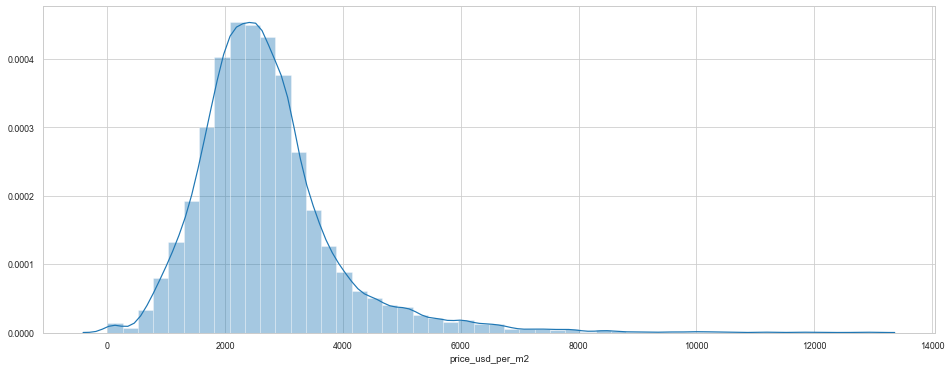

In [9]:
plt.figure(figsize=(16,6))
df_aux = df[df["price_usd_per_m2"] < 20000]
ax = sns.distplot(df_aux["price_usd_per_m2"])

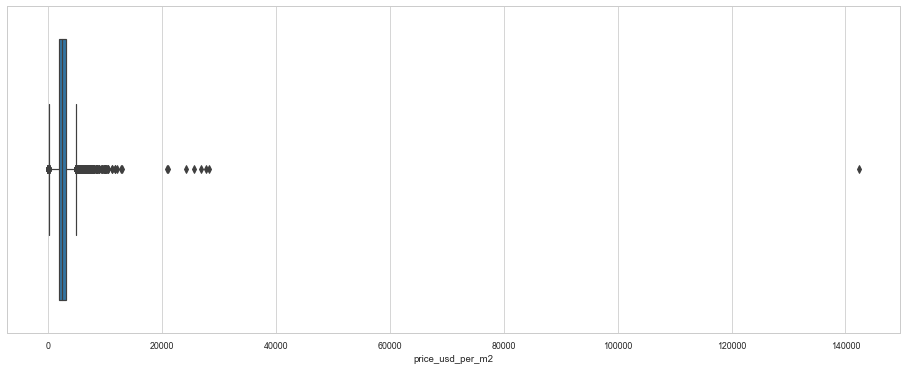

In [10]:
# El boxplot debe estar en esta celda
plt.figure(figsize=(16,6))
sns.boxplot(df['price_usd_per_m2'])

¿A qué conclusión podemos llegar observando estas figuras?
**Responder**

In [11]:
# Se puede visualizar en el histograma de precios (U$D) de propiedades por m2 que :
# 1) Hay un pico de propiedades que rondan el valor de U$D 2500 
# 2) Se puede ver una asimetria pronunciada hacia la derecha
# 3) Se aprecian valores atipicos rondando los  U$D 140000 
# Se puede ver en el grafico de caja que:
# 1) Se puede ver que claramente que hay mas outliers de lo que se puede ver en el histograma.
# 2) Como se pudo ver en el histograma hay una asimetria de los datos hacia la derecha
# Conclusión: Se puede ver que el precio por m2 de la gran la mayoria de las propiedades ronda en los U$D 2500
# y hay valores exorbitantes de propiedades  que distorsionan los datos (outliers). Estos deben ser eliminados para
# que no haya sesgo estadistico. 

In [12]:
df['price_usd_per_m2'].describe()

count     12973.000000
mean       2695.065767
std        1773.086831
min           0.958333
25%        1959.183673
50%        2510.204082
75%        3125.000000
max      142450.141026
Name: price_usd_per_m2, dtype: float64

In [13]:
print("Rango Intercuartilíco: [%s]"% (df['price_usd_per_m2'].quantile(0.75) - df['price_usd_per_m2'].quantile(0.25))) 

Rango Intercuartilíco: [1165.8163265306118]


In [14]:
# Realizar el filtrado intercuartílico en esta celda
q75, q25 = np.percentile(df.price_usd_per_m2, [75,25])
iqr =q75 - q25 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

In [15]:
df.price_usd_per_m2[df.price_usd_per_m2 > max]

0        6410.256410
9        6500.000000
10       5360.824742
14       5833.333333
21       5500.000000
            ...     
12301    6911.764706
12329    6315.789474
12341    7209.302326
12531    6363.636364
12532    6363.636364
Name: price_usd_per_m2, Length: 639, dtype: float64

In [16]:
df_filtered = df[df.price_usd_per_m2 < max]

In [17]:
df_filtered.shape

(12334, 15)

**5)** Volver a **plotear** con `distplot` y `boxplot` los precios sin los outliers y observá las diferencias con los anteriores ploteo.

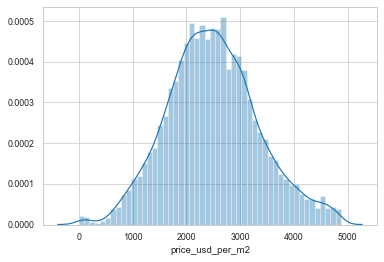

In [18]:
sns.distplot(df_filtered['price_usd_per_m2'])

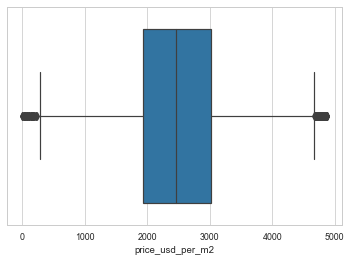

In [19]:
sns.boxplot(df_filtered['price_usd_per_m2'])

In [20]:
df_filtered.price_usd_per_m2.describe()

count    12334.000000
mean      2496.085132
std        846.294783
min          0.958333
25%       1928.195489
50%       2464.026915
75%       3025.641026
max       4871.794872
Name: price_usd_per_m2, dtype: float64

Vamos a seguir trabajando con el `dataframe` filtrado

In [21]:
df = df_filtered

### Valores Faltantes

A diferencia del proyecto pasado, vamos a intentar imputar los valores faltantes para los atributos que consideramos importantes para el mercado inmobiliario. 

Estos atributos son los que informan **superficie (total o cubierta), cantidad de ambientes, precio y precio por metro cuadrado**. 

Veamos en primer lugar cuántos valores faltantes tiene cada atributo. Nos interesa verlo como un porcentaje en relación a la cantidad de observaciones. Si un atributo tiene un elevado porcentaje de faltantes, puede ser mejor no considerarlo en el análisis.

In [22]:
print("Valores faltantes de Superficie Total {} %".format(df.surface_total_in_m2.isnull().sum() * 100 / len(df)))
print("Valores faltantes de Superficie Cubierta {} %".format(df.surface_covered_in_m2.isnull().sum() * 100 / len(df)))
print("Valores faltantes de Cantidad de ambientes {} %".format(df.floor.isnull().sum() * 100 / len(df)))
print("Valores faltantes de Pisos (U$D) {} %".format(df.price_usd_per_m2.isnull().sum() * 100 / len(df)))
print("Valores faltantes de Precio (U$D) {} %".format(df.price_aprox_usd.isnull().sum() * 100 / len(df)))
print("Valores faltantes de Precio por m2 (U$D) {} %".format(df.price_usd_per_m2.isnull().sum() * 100 / len(df)))
print("Valores faltantes de Expensas {} %".format(df.expenses.isnull().sum() * 100 / len(df)))


Valores faltantes de Superficie Total 0.0 %
Valores faltantes de Superficie Cubierta 3.867358521161018 %
Valores faltantes de Cantidad de ambientes 85.08188746554241 %
Valores faltantes de Pisos (U$D) 0.0 %
Valores faltantes de Precio (U$D) 0.0 %
Valores faltantes de Precio por m2 (U$D) 0.0 %
Valores faltantes de Expensas 74.00681044267877 %


In [23]:
#Otra forma
print("Valores faltantes de Superficie Total {} %".format(df.surface_total_in_m2.isnull().mean() * 100))
print("Valores faltantes de Superficie Cubierta {} %".format(df.surface_covered_in_m2.isnull().mean()*100))
print("Valores faltantes de Cantidad de ambientes {} %".format(df.floor.isnull().mean()*100))
print("Valores faltantes de Pisos (U$D) {} %".format(df.price_usd_per_m2.isnull().mean()*100))
print("Valores faltantes de Precio (U$D) {} %".format(df.price_aprox_usd.isnull().mean()*100))
print("Valores faltantes de Precio por m2 (U$D) {} %".format(df.price_usd_per_m2.isnull().mean()*100))
print("Valores faltantes de Expensas {} %".format(df.expenses.isnull().mean()*100))

Valores faltantes de Superficie Total 0.0 %
Valores faltantes de Superficie Cubierta 3.8673585211610186 %
Valores faltantes de Cantidad de ambientes 85.08188746554241 %
Valores faltantes de Pisos (U$D) 0.0 %
Valores faltantes de Precio (U$D) 0.0 %
Valores faltantes de Precio por m2 (U$D) 0.0 %
Valores faltantes de Expensas 74.00681044267877 %


Podemos ver en los resultados que los atributos `floor` y `expenses` tienen un elevado porcentaje de faltantes.  Una opción sería descartar estas columnas en el análisis. 
Si elimináramos las observaciones (filas) asociadas a estos, perderíamos el 84.79% de los datos, mermando demasiado el conjunto de datos.

Otra opción sería por ejemplo considerar categorías como faltantes o no faltantes o en todo caso analizar si hay algún patrón para poder evitar quitarlos. 

Para avanzar con el proyecto, vamos a quitar esos atributos.

In [24]:
df = df.drop(['floor', 'expenses'], axis = 1)

In [25]:
df

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.00,130.0,120.0,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.00,52.0,48.0,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.00,70.0,70.0,2571.428571,NaN,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO
5,2017-08-30,house,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.00,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,2017-12-17,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668970,-58.443897,49000.00,75.0,75.0,653.333333,4.0,https://www.properati.com.ar/1j22x_venta_depar...,VILLA SOLDATI
13752,2018-01-08,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.668741,-58.443146,60000.00,55.0,55.0,1090.909091,3.0,https://www.properati.com.ar/1jcpm_venta_depar...,VILLA SOLDATI
13753,2018-01-23,house,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.664170,-58.443317,99000.00,115.0,82.0,860.869565,3.0,https://www.properati.com.ar/1k1hs_venta_casa_...,VILLA SOLDATI
13754,2018-01-27,apartment,Villa Soldati,|Argentina|Capital Federal|Villa Soldati|,-34.665005,-58.443041,50433.01,45.0,45.0,1120.733556,3.0,https://www.properati.com.ar/1k5v0_venta_depar...,VILLA SOLDATI


Analicemos estrategias para imputar los valores faltantes para los atributos `rooms`, `surface_total_in_m2` y `surface_covered_in_m2`.

Como vimos en las actividades, entre las opciones que tenemos está la posibilidad de imputar por algún medida de tendencia central, como el caso de la media o la mediana. Vamos a avanzar en esa dirección.

In [26]:
from sklearn.impute import SimpleImputer  #Investigando descubri que Imputer se ha cambiado por SimpleImputer 

In [27]:
X = df.surface_total_in_m2.values
Y = df.surface_covered_in_m2.values

In [28]:
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X.reshape(-1,1))
Y2 = imp.fit_transform(Y.reshape(-1,1))

In [29]:
df.surface_total_in_m2 = X2

In [30]:
df.surface_covered_in_m2 = Y2

Una de las limitaciones que presenta este tipo de imputación es que provoca estimaciones sesgadas de la varianza. Esto impacta en los errores estandar y, por ende, en los tests estadístcos.

Este tipo de técnicas es útil cuando los valores son completamente al azar.

In [31]:
# Imputar con la mediana en esta celda
Z = df.rooms.values

In [32]:
imp = SimpleImputer(strategy='median')
Z2 = imp.fit_transform(Z.reshape(-1,1))

In [33]:
df.rooms = Z2

### Variables binarias

#### Generar variables binarias para el atributo `property_type`.

Hay que tener en cuenta en este caso que el atributo es categórico.

Para hacerlo usando scikit-learn, por como vienen dados los valores (en formato string), primero conviene convertirlos en numéricos. Para esto usamos `LabelEncoder`.

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df.property_type.values)
le.transform(df.property_type)

array([1, 1, 1, ..., 2, 1, 1])

**11) Mostrar** las clases del `LabelEncoder`:

In [35]:
le.classes_

array(['PH', 'apartment', 'house'], dtype=object)

Luego con `OneHotEncoder` obtenemos las categorías expresadas como **variables binarias**. 

In [36]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse = False)
enc = df.property_type.values.reshape(-1,1)

In [37]:
onehot_encoder.fit(enc)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [38]:
onehot_encoder.categories_

[array(['PH', 'apartment', 'house'], dtype=object)]

In [39]:
onehot_encoder.transform(enc)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [40]:
enc

array([['apartment'],
       ['apartment'],
       ['apartment'],
       ...,
       ['house'],
       ['apartment'],
       ['apartment']], dtype=object)

In [41]:
categoricals_df = pd.DataFrame(enc)

Unimos el nuevo dataframe `categorical_df` con el `dataframe` original `df`. Para esto, necesitamos que tengan el mismo índice.

In [42]:
categoricals_df = categoricals_df.set_index(df.index)
df = pd.concat([df, categoricals_df], axis=1)
df.head()

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio,0
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.0,130.0,120.0,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO,apartment
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.0,52.0,48.0,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO,apartment
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.0,70.0,70.0,2571.428571,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO,apartment
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO,house
5,2017-08-30,house,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO,house


In [43]:
df_2 = pd.get_dummies(data=categoricals_df) #Shortcut
df = pd.concat([df, df_2], axis=1)
df.head()

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio,0,0_PH,0_apartment,0_house
1,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.588912,-58.413494,340000.0,130.0,120.0,2615.384615,4.0,https://www.properati.com.ar/1dzv6_venta_depar...,PALERMO,apartment,0,1,0
2,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.577033,-58.423368,222000.0,52.0,48.0,4269.230769,1.0,https://www.properati.com.ar/1e05k_venta_depar...,PALERMO,apartment,0,1,0
3,2017-08-29,apartment,Palermo,|Argentina|Capital Federal|Palermo|,-34.595014,-58.427392,180000.0,70.0,70.0,2571.428571,3.0,https://www.properati.com.ar/1e0mq_venta_depar...,PALERMO,apartment,0,1,0
4,2017-08-30,house,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1ve_venta_casa_...,PALERMO,house,0,0,1
5,2017-08-30,house,Palermo,|Argentina|Capital Federal|Palermo|,-34.579354,-58.436449,1200000.0,532.0,334.0,2255.639098,6.0,https://www.properati.com.ar/1e1vf_venta_casa_...,PALERMO,house,0,0,1


### Variables calculadas

El hecho de crear una columna nueva y no imputar los faltantes es simplemente una decisión. Cuando veamos modelos predictivos, vamos a poder cuantificar el costo de las decisiones que tomemos en términos de performance del modelo.

In [44]:
def custom_division(x, y):
    if y > 0:
        res = x / y
    else:
        res = 0
    return res

df['price_m2'] = df.apply(lambda x: custom_division(x['price_aprox_usd'], x['surface_total_in_m2']), axis = 1)
df.drop(['price_usd_per_m2'], axis=1, inplace=True)

In [45]:
# Creamos un dataset con los porcentajes de nulos
df_faltantes = pd.DataFrame(df.isnull().sum() / df.shape[0], columns=['Porcentaje nulos'])
# Solo mostramos los que tengan valores nulos. Si el porcentaje es 0 no se muestra
df_faltantes.loc[~(df_faltantes==0).all(axis=1)]

,Porcentaje nulos


In [46]:
print("El dataset final luego del procesamiento tiene {} observaciones".format(df.shape[0]))

El dataset final luego del procesamiento tiene 12334 observaciones


De este modo, hemos limpiado valores extremos e imputado valores nulos. El costo de esto fue la pérdida de 685 observaciones, 5% de la cantidad original de filas.